In [1]:
import scanpy as sc
import pandas as pd
import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from compute_transport import *
import torch
import torch.nn.functional as F
from evaluation_metrics import *

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, frameon=False, figsize=(20, 10), facecolor='white')

-----
anndata     0.11.3
scanpy      1.10.4
-----
PIL                         11.1.0
anyio                       NA
appnope                     0.1.2
asttokens                   NA
attr                        24.3.0
attrs                       24.3.0
babel                       2.16.0
backports                   NA
brotli                      1.0.9
certifi                     2025.01.31
charset_normalizer          3.3.2
comm                        0.2.1
compute_transport           NA
cycler                      0.12.1
cython_runtime              NA
dateutil                    2.9.0.post0
debugpy                     1.8.11
decorator                   5.1.1
defusedxml                  0.7.1
einops                      0.8.1
evaluation_metrics          NA
exceptiongroup              1.2.0
executing                   0.8.3
fastjsonschema              NA
h5py                        3.12.1
idna                        3.7
ipykernel                   6.29.5
ipywidgets                  8.1.5
ja

/Users/muqiao/miniforge3/envs/torch_env/lib/python3.10/site-packages/session_info/main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)


In [3]:
df_ms = pd.read_pickle('ms_df_bc.pkl')
df_ms

_index,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
6,0,0,0,0,0,0,0,0,0,0,...,1.181849,1.181849,1.181849,0,0,0,0,0,0,0
5,0,0,0.995651,0.995651,0,0,0,0,0,0,...,1.811473,0,0,0,0,0,0.995651,0,0,0
14,0,0,1.176548,1.176548,0,0,1.702257,0,0,0,...,1.176548,0,0,0,0,1.176548,1.176548,0,0,0
14,0,0,0,0,0,0,0,0,0,0,...,0,1.861259,0,0,0,1.861259,0,0,0,0
1,0,0,0,0,0,2.068235,0,0,0,0,...,0,0,0,0,0,2.068235,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,0,0,0,1.087015,1.087015,1.087015,0,0,0,0,...,0,0,0,0,0,0,1.087015,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
14,0,0,0,1.092912,1.092912,0,0,0,0,0,...,0,1.092912,0,0,0,0,1.602593,0,0,0


In [4]:
# transform cell type index into a number between 100 and 200
df_ms.index = df_ms.index+101
df_ms

_index,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
107,0,0,0,0,0,0,0,0,0,0,...,1.181849,1.181849,1.181849,0,0,0,0,0,0,0
106,0,0,0.995651,0.995651,0,0,0,0,0,0,...,1.811473,0,0,0,0,0,0.995651,0,0,0
115,0,0,1.176548,1.176548,0,0,1.702257,0,0,0,...,1.176548,0,0,0,0,1.176548,1.176548,0,0,0
115,0,0,0,0,0,0,0,0,0,0,...,0,1.861259,0,0,0,1.861259,0,0,0,0
102,0,0,0,0,0,2.068235,0,0,0,0,...,0,0,0,0,0,2.068235,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,0,0,0,1.087015,1.087015,1.087015,0,0,0,0,...,0,0,0,0,0,0,1.087015,0,0,0
109,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
115,0,0,0,1.092912,1.092912,0,0,0,0,0,...,0,1.092912,0,0,0,0,1.602593,0,0,0


In [5]:
df_mk = pd.read_pickle('mk_df_bc.pkl')
df_mk = df_mk[df_mk.index != 'OFFx']
df_mk

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
FMB,0,0,0,0,0,0,1.700059,0,0,0,...,0,1.700059,0,0,0,0,0,0,0,0
FMB,0,0,0,0,1.429261,0,0,0,0,0,...,1.429261,0,0,1.429261,0,0,0,0,0,0
DB3b,0,0,0,0,1.61781,1.61781,0,0,0,0,...,1.61781,0,0,0,0,1.61781,0,0,0,0
DB4,0,0,0,1.77109,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.965367,0
FMB,0,0,0,0,0,0,1.460467,0,0,0,...,0,0,0,0,1.460467,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMB,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.880784,0,0,0
DB5*,0,0,2.18944,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
IMB,0,0,0,0,1.62826,0,0,0,0,0,...,1.62826,1.62826,0,0,0,0,0,0,0,0


In [6]:
# Generate unique mapping for index values
unique_index_values = df_mk.index.unique()
index_mapping = {key: value for value, key in enumerate(unique_index_values)}

# Display the mapping
print("Mapping of annotated values to numbers:")
print(index_mapping)

# Optionally, create a new column with numeric representation
df_mk.index = df_mk.index.map(index_mapping)
df_mk

Mapping of annotated values to numbers:
{'FMB': 0, 'DB3b': 1, 'DB4': 2, 'IMB': 3, 'DB2': 4, 'DB5*': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}


,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,1.700059,0,0,0,...,0,1.700059,0,0,0,0,0,0,0,0
0,0,0,0,0,1.429261,0,0,0,0,0,...,1.429261,0,0,1.429261,0,0,0,0,0,0
1,0,0,0,0,1.61781,1.61781,0,0,0,0,...,1.61781,0,0,0,0,1.61781,0,0,0,0
2,0,0,0,1.77109,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.965367,0
0,0,0,0,0,0,0,1.460467,0,0,0,...,0,0,0,0,1.460467,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.880784,0,0,0
5,0,0,2.18944,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1.62826,0,0,0,0,0,...,1.62826,1.62826,0,0,0,0,0,0,0,0


In [7]:
# transform cell type index into a number above 200
df_mk.index = df_mk.index+201
df_mk

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
201,0,0,0,0,0,0,1.700059,0,0,0,...,0,1.700059,0,0,0,0,0,0,0,0
201,0,0,0,0,1.429261,0,0,0,0,0,...,1.429261,0,0,1.429261,0,0,0,0,0,0
202,0,0,0,0,1.61781,1.61781,0,0,0,0,...,1.61781,0,0,0,0,1.61781,0,0,0,0
203,0,0,0,1.77109,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0.965367,0
201,0,0,0,0,0,0,1.460467,0,0,0,...,0,0,0,0,1.460467,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1.880784,0,0,0
206,0,0,2.18944,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
204,0,0,0,0,1.62826,0,0,0,0,0,...,1.62826,1.62826,0,0,0,0,0,0,0,0


In [8]:
# mk_index_mapping = {'FMB': 0, 'DB3b': 1, 'DB4': 2, 'IMB': 3, 'DB2': 4, 'DB5*': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'OFFx': 10, 'DB3a': 11}
mk_index_mapping = {'FMB': 0, 'DB3b': 1, 'DB4': 2, 'IMB': 3, 'DB2': 4, 'DB5*': 5, 'DB1': 6, 'BB/GB*': 7, 'RB': 8, 'DB6': 9, 'DB3a': 10}

In [9]:
mk_bc_mapping = {value: key for key, value in mk_index_mapping.items()}
mk_bc_mapping

{0: 'FMB',
 1: 'DB3b',
 2: 'DB4',
 3: 'IMB',
 4: 'DB2',
 5: 'DB5*',
 6: 'DB1',
 7: 'BB/GB*',
 8: 'RB',
 9: 'DB6',
 10: 'DB3a'}

In [10]:
ms_bc_mapping = {
    0:"BC1A",
    1:"BC1B",
    2:"BC2",
    3:"BC3A",
    4:"BC3B",
    5:"BC4",
    6:"BC5A",
    7:"BC5B",
    8:"BC5C",
    9:"BC5D",
    10:"BC6",
    11:"BC7",
    12:"BC8/9",
    13:"BC8/9",
    14:"RBC"
}
ms_bc_mapping

{0: 'BC1A',
 1: 'BC1B',
 2: 'BC2',
 3: 'BC3A',
 4: 'BC3B',
 5: 'BC4',
 6: 'BC5A',
 7: 'BC5B',
 8: 'BC5C',
 9: 'BC5D',
 10: 'BC6',
 11: 'BC7',
 12: 'BC8/9',
 13: 'BC8/9',
 14: 'RBC'}

In [11]:
df = pd.concat([df_ms, df_mk], axis=0)
df = df.sparse.to_dense()
df

,TRIM58,NLRP3,SCCPDH,CNST,COX20,DESI2,SDCCAG8,EXO1,WDR64,KMO,...,ATP6AP1,GDI1,FAM50A,PLXNA3,IKBKG,BRCC3,VBP1,SPRY3,VAMP7,IL9R
annotated,,,,,,,,,,,,,,,,,,,,,
107,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,1.181849,1.181849,1.181849,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
106,0.0,0.000000,0.995651,0.995651,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,1.811473,0.000000,0.000000,0.0,0.0,0.000000,0.995651,0.0,0.000000,0.0
115,0.0,0.000000,1.176548,1.176548,0.000000,0.000000,1.702257,0.0,0.0,0.0,...,1.176548,0.000000,0.000000,0.0,0.0,1.176548,1.176548,0.0,0.000000,0.0
115,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,1.861259,0.000000,0.0,0.0,1.861259,0.000000,0.0,0.000000,0.0
102,0.0,0.000000,0.000000,0.000000,0.000000,2.068235,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,2.068235,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.880784,0.0,0.000000,0.0
206,0.0,0.000000,2.189440,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0
204,0.0,0.000000,0.000000,0.000000,1.628260,0.000000,0.000000,0.0,0.0,0.0,...,1.628260,1.628260,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0


In [12]:
# Calculate counts, means, and variances per cell type
type_counts = df.groupby(df.index).count()  # Count of cells per type
type_means = df.groupby(df.index).mean()    # Mean expression per type
type_vars = df.groupby(df.index).var()      # Variance per type

# Calculate SEM for each type
type_sems = type_vars.div(type_counts - 1).pow(0.5)  # SEM = sqrt(var/(n-1))

# Calculate overall mean expression for each gene
overall_means = df.mean()

# Calculate signal
signal = ((type_means - overall_means)**2).sum()

# Calculate noise
noise = (type_sems**2).sum()

# Calculate SNR, avoiding division by zero
snr = signal / np.maximum(noise, 1e-20)

# Sort genes by SNR in descending order
sorted_genes = snr.sort_values(ascending=False)

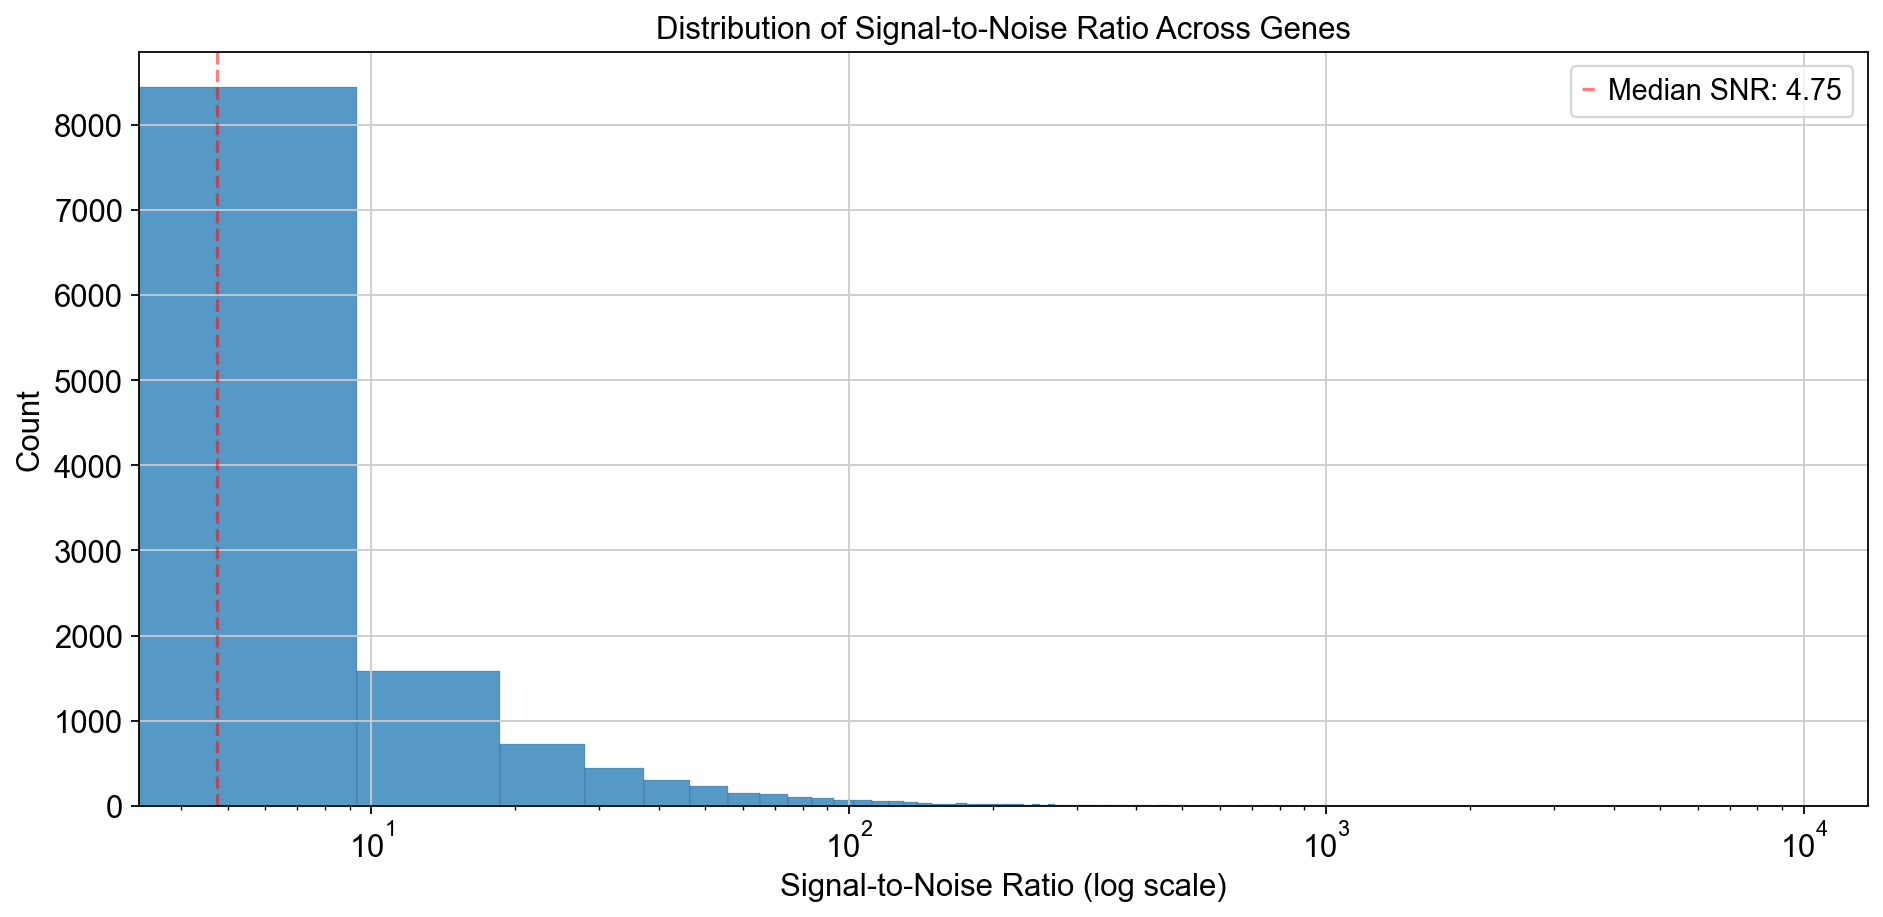


SNR Summary Statistics:
count    13040.000000
mean        30.736056
std        144.836431
min          0.000000
25%          1.820710
50%          4.754049
75%         16.546086
max       9321.299868
dtype: float64


In [13]:
# Create figure
plt.figure(figsize=(12, 6))

# Plot histogram with KDE
sns.histplot(data=snr, bins=1000)

# Add log scale for x-axis since SNR values often span several orders of magnitude
plt.xscale('log')

# Customize the plot
plt.title('Distribution of Signal-to-Noise Ratio Across Genes')
plt.xlabel('Signal-to-Noise Ratio (log scale)')
plt.ylabel('Count')

# Add grid for better readability
# plt.grid(True, which="both", ls="-", alpha=0.2)

# Optional: Add vertical line at median
plt.axvline(snr.median(), color='r', linestyle='--', alpha=0.5, label=f'Median SNR: {snr.median():.2f}')
plt.legend()

plt.tight_layout()
plt.show()

# Print some summary statistics
print("\nSNR Summary Statistics:")
print(snr.describe())

In [14]:
# Select genes with high SNR
high_snr_genes = snr[snr > 100]

# Print number of selected genes
print(f"Number of genes with great SNR: {len(high_snr_genes)}")

# Create filtered dataframe with only high SNR genes
df_filtered = df[high_snr_genes.index]

# Optional: Display first few rows and shape of filtered dataframe
print(f"\nShape of filtered dataframe: {df_filtered.shape}")
print("\nFirst few rows of filtered dataframe:")
print(df_filtered.head())

Number of genes with great SNR: 790

Shape of filtered dataframe: (25403, 790)

First few rows of filtered dataframe:
              CHRM3      RYR2  ACTN2  SLC35F3  DISC1  CCDC181   F5  TNFSF4  \
annotated                                                                    
107        3.161415  2.948807    0.0      0.0    0.0      0.0  0.0     0.0   
106        3.401539  2.560740    0.0      0.0    0.0      0.0  0.0     0.0   
115        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   
115        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   
102        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   

                TNR     RGS16  ...  SCML1  PGK1   GPRASP2      BEX4    TCEAL9  \
annotated                      ...                                              
107        0.000000  1.181849  ...    0.0   0.0  0.000000  1.181849  0.000000   
106        1.484548  0.000000  ...    0.0   0.0  0.995651  0.995651  1.811473   
115        

In [15]:
# Split into mouse and macaque dataframes
ms_sub_df = df_filtered[df_filtered.index < 200]
mk_sub_df = df_filtered[df_filtered.index >= 200]

# Print information about the split
print(f"Mouse dataframe shape: {ms_sub_df.shape}")
print(f"Macaque dataframe shape: {mk_sub_df.shape}")

# Optional: Display first few rows of each
print("\nFirst few rows of mouse dataframe:")
print(ms_sub_df.head())
print("\nFirst few rows of macaque dataframe:")
print(mk_sub_df.head())

Mouse dataframe shape: (5555, 790)
Macaque dataframe shape: (19848, 790)

First few rows of mouse dataframe:
              CHRM3      RYR2  ACTN2  SLC35F3  DISC1  CCDC181   F5  TNFSF4  \
annotated                                                                    
107        3.161415  2.948807    0.0      0.0    0.0      0.0  0.0     0.0   
106        3.401539  2.560740    0.0      0.0    0.0      0.0  0.0     0.0   
115        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   
115        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   
102        0.000000  0.000000    0.0      0.0    0.0      0.0  0.0     0.0   

                TNR     RGS16  ...  SCML1  PGK1   GPRASP2      BEX4    TCEAL9  \
annotated                      ...                                              
107        0.000000  1.181849  ...    0.0   0.0  0.000000  1.181849  0.000000   
106        1.484548  0.000000  ...    0.0   0.0  0.995651  0.995651  1.811473   
115        2.671314 

In [16]:
# transform the index back to cell type names
mk_sub_df.index = mk_sub_df.index - 201
mk_sub_df.index = mk_sub_df.index.map(mk_bc_mapping)
mk_sub_df

,CHRM3,RYR2,ACTN2,SLC35F3,DISC1,CCDC181,F5,TNFSF4,TNR,RGS16,...,SCML1,PGK1,GPRASP2,BEX4,TCEAL9,IL1RAPL2,COL4A5,NDUFA1,GRIA3,LDOC1
annotated,,,,,,,,,,,,,,,,,,,,,
FMB,0.0,1.700059,0.00000,0.000000,0.000000,1.700059,1.700059,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.0,1.700059,0.000000,0.000000,0.000000,0.0
FMB,0.0,2.617574,0.00000,0.000000,0.000000,1.429261,0.000000,0.000000,0.0,0.000000,...,1.429261,0.000000,0.000000,1.994867,0.0,1.429261,0.000000,0.000000,0.000000,0.0
DB3b,0.0,0.000000,1.61781,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,2.206523,0.0,1.617810,0.000000,1.617810,0.000000,0.0
DB4,0.0,0.965367,0.00000,1.447273,1.771090,1.771090,0.000000,1.447273,0.0,0.000000,...,0.000000,0.965367,1.447273,0.000000,0.0,0.000000,0.965367,1.771090,1.771090,0.0
FMB,0.0,0.000000,0.00000,0.000000,0.000000,1.460467,2.030244,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,2.030244,0.0,0.000000,0.000000,1.460467,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
IMB,0.0,0.000000,0.00000,0.000000,1.880784,0.000000,0.000000,1.880784,0.0,1.880784,...,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,2.494633,0.000000,0.0
DB5*,0.0,3.210466,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,2.824969,0.0,0.000000,0.000000,2.189440,0.000000,0.0
IMB,0.0,0.000000,1.62826,0.000000,1.628260,0.000000,0.000000,0.000000,0.0,2.218117,...,0.000000,1.628260,0.000000,1.628260,0.0,0.000000,0.000000,3.066890,0.000000,0.0


In [17]:
# transform the index back to cell type names
ms_sub_df.index = ms_sub_df.index - 101
ms_sub_df.index = ms_sub_df.index.map(ms_bc_mapping)
ms_sub_df

,CHRM3,RYR2,ACTN2,SLC35F3,DISC1,CCDC181,F5,TNFSF4,TNR,RGS16,...,SCML1,PGK1,GPRASP2,BEX4,TCEAL9,IL1RAPL2,COL4A5,NDUFA1,GRIA3,LDOC1
annotated,,,,,,,,,,,,,,,,,,,,,
BC5A,3.161415,2.948807,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.181849,...,0.0,0.0,0.000000,1.181849,0.000000,0.000000,0.0,0.000000,0.000000,0.0
BC4,3.401539,2.560740,0.0,0.0,0.0,0.0,0.0,0.0,1.484548,0.000000,...,0.0,0.0,0.995651,0.995651,1.811473,0.000000,0.0,0.000000,0.000000,0.0
RBC,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.671314,1.702257,...,0.0,0.0,0.000000,1.702257,0.000000,0.000000,0.0,1.176548,0.000000,0.0
RBC,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.850446,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
BC1B,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
BC3B,3.279042,2.382047,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.0,0.000000,1.087015,2.382047,0.000000,0.0,0.000000,1.595505,0.0
BC5C,0.000000,1.895055,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.895055,...,0.0,0.0,0.000000,1.895055,0.000000,2.510073,0.0,0.000000,0.000000,0.0
RBC,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.189616,1.092912,...,0.0,0.0,0.000000,0.000000,1.602593,0.000000,0.0,1.602593,0.000000,0.0


In [18]:
# Calculate mean expression per cell type for both species
ms_type_means = ms_sub_df.groupby(ms_sub_df.index).mean()
mk_type_means = mk_sub_df.groupby(mk_sub_df.index).mean()

# Convert to torch tensors
ms_tensor = torch.tensor(ms_type_means.values, dtype=torch.float32)
mk_tensor = torch.tensor(mk_type_means.values, dtype=torch.float32)

# Normalize the vectors
ms_norm = F.normalize(ms_tensor, dim=1)
mk_norm = F.normalize(mk_tensor, dim=1)

# Compute cosine similarity (1 - cosine distance)
distance_matrix = pd.DataFrame(
    1- torch.mm(mk_norm, ms_norm.t()).numpy(),
    index=mk_type_means.index,
    columns=ms_type_means.index
)

In [19]:
# for plotting in the same order as that in Peng, et al. (2019)
desired_order = [
    "FMB",    # FMB (top)
    # "OFFx",   # OFFx
    "DB1",    # DB1
    "DB3a",   # DB3a
    "DB3b",   # DB3b
    "DB2",    # DB2
    "DB4",    # DB4
    "DB5*",   # DB5*
    "DB6",    # DB6
    "IMB",    # IMB
    "BB/GB*", # BB/GB*
    "RB"      # RB (bottom)
]

In [20]:
def plot_transport_comparison(distance_matrix, mesh_lr=1.0, n_mesh_iters=4,
                            temperature=1.0, n_sh_iters=5):
    """
    Plot and compare regular Sinkhorn vs sparse Sinkhorn transport matrices.
    """
    # Regular Sinkhorn
    regular_transport = compute_regular_transport(
        distance_matrix, 
        temperature=temperature,
        n_sh_iters=n_sh_iters
    )
    
    # Sparse Sinkhorn with MESH
    sparse_transport = compute_sparse_transport(
        distance_matrix,
        mesh_lr=mesh_lr,
        n_mesh_iters=n_mesh_iters,
        temperature=temperature,
        n_sh_iters=n_sh_iters
    )
    
# Plot both
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(9.5, 12))
    
    sns.heatmap(regular_transport, cmap='bwr', square=False, annot=False,
                fmt='.3f', ax=ax1)
    ax1.set_title('Regular Sinkhorn Transport', fontsize=12)
    ax1.set_xlabel('Mouse BC Types', fontsize=12)
    ax1.set_ylabel('Macaque BC Types', fontsize=12)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0, fontsize=12)
    ax1.set_yticklabels(ax1.get_yticklabels(), rotation=0, fontsize=12)
    
    sns.heatmap(sparse_transport, cmap='bwr', square=False, annot=False,
                fmt='.3f', ax=ax2)
    ax2.set_title('Sparse Sinkhorn Transport (with MESH)', fontsize=12)
    ax2.set_xlabel('Mouse BC Types', fontsize=12)
    ax2.set_ylabel('Macaque BC Types', fontsize=12)
    ax2.set_xticklabels(ax2.get_xticklabels(), rotation=0, fontsize=12)
    ax2.set_yticklabels(ax2.get_yticklabels(), rotation=0, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('./Plots/ot_bcs.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print sparsity comparison
    regular_sparsity = (regular_transport < 0.001).sum().sum() / regular_transport.size
    sparse_sparsity = (sparse_transport < 0.001).sum().sum() / sparse_transport.size
    print(f"\nSparsity comparison (percentage of elements < 0.01):")
    print(f"Regular Sinkhorn: {regular_sparsity:.1%}")
    print(f"Sparse Sinkhorn: {sparse_sparsity:.1%}")
    return regular_transport, sparse_transport

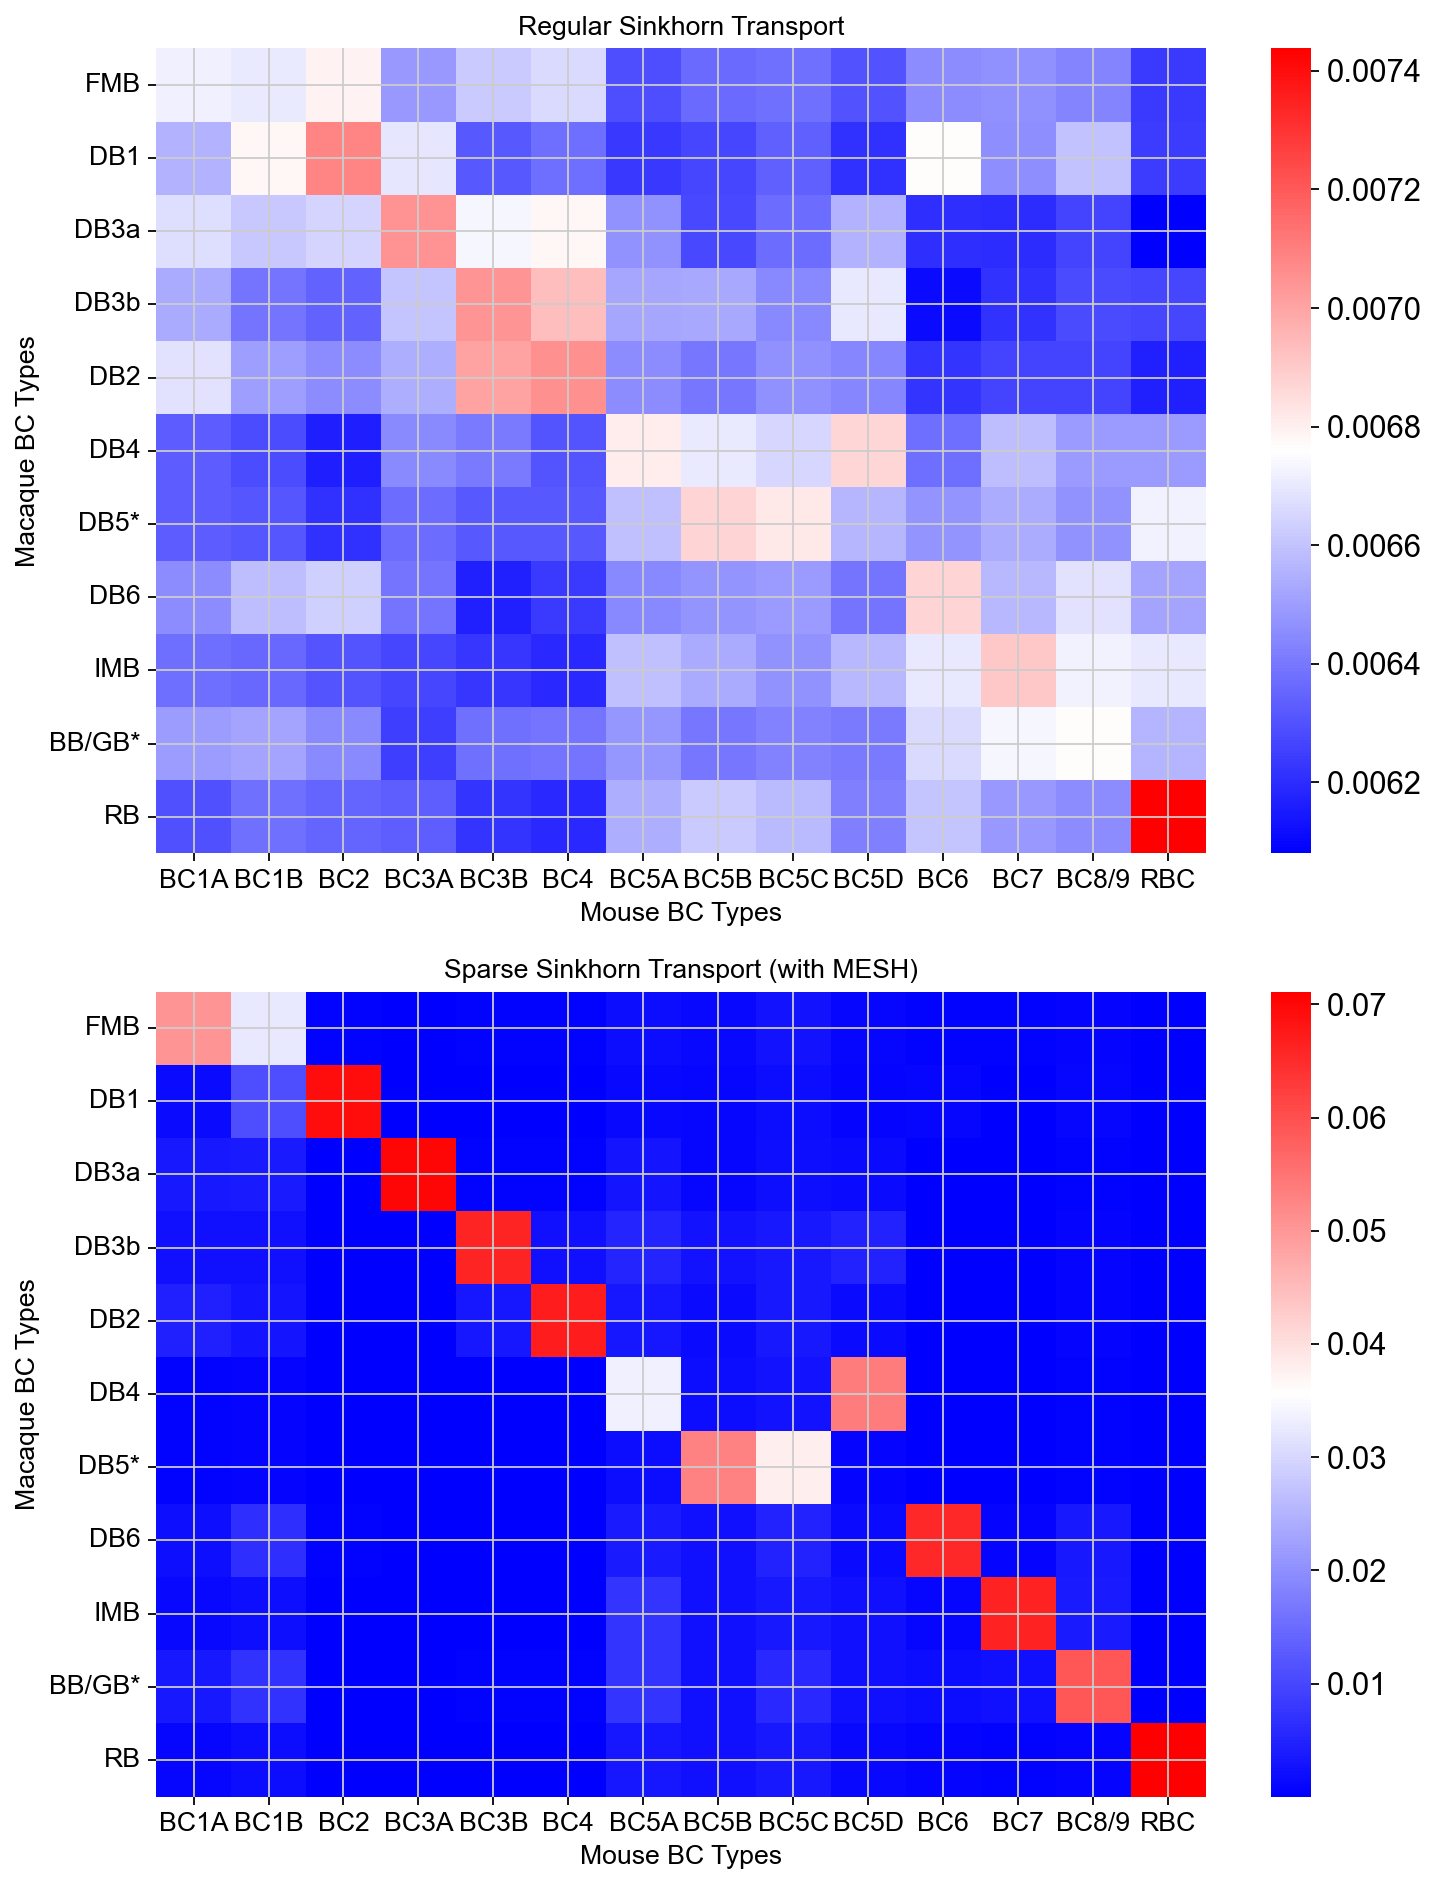


Sparsity comparison (percentage of elements < 0.01):
Regular Sinkhorn: 0.0%
Sparse Sinkhorn: 53.2%


In [21]:
# Visualize comparison
regular_transport, sparse_transport = plot_transport_comparison(
    distance_matrix.loc[desired_order,:],
    mesh_lr=5.0,
    n_mesh_iters=4,
    temperature=1.0,
    n_sh_iters=5
)

In [25]:
# for sparse_transport
matrix = sparse_transport

# Ensure the matrix is normalized
if not np.isclose(matrix.values.sum(), 1.0):
    matrix = matrix / matrix.values.sum()

# Calculate metrics
sparseness = sparseness_score(matrix.values)
entropy_value = entropy(matrix.values)

# Print results
print("\nCorrespondence Matrix Evaluation Results:")
print("----------------------------------------")
print(f"Sparseness Score: {sparseness:.4f}")
print(f"Entropy: {entropy_value:.4f}")

# Additional information about the matrix
print("\nMatrix Information:")
print(f"Shape: {matrix.shape}")
print(f"Number of cells: {matrix.size}")
print(f"Number of cells with value > 0.001: {np.sum(matrix.values > 0.001)}")
print(f"Maximum value: {matrix.values.max():.4f}")

# Top correspondences
alignment_scores = calculate_alignment_scores(matrix).flatten()
top_indices = np.argsort(alignment_scores)[-14:][::-1]  # Get indices of top 10 values
rows, cols = np.unravel_index(top_indices, matrix.shape)

print("\nTop 14 Strongest Correspondences:")
for i in range(len(top_indices)):
    row_name = matrix.index[rows[i]]
    col_name = matrix.columns[cols[i]]
    value = alignment_scores[top_indices[i]]
    print(f"{row_name} → {col_name}: {value:.4f}")




Correspondence Matrix Evaluation Results:
----------------------------------------
Sparseness Score: 0.5325
Entropy: 3.4607

Matrix Information:
Shape: (11, 14)
Number of cells: 154
Number of cells with value > 0.001: 72
Maximum value: 0.0711

Top 14 Strongest Correspondences:
RB → RBC: 0.9101
DB3a → BC3A: 0.8930
DB1 → BC2: 0.8731
DB2 → BC4: 0.8458
IMB → BC7: 0.8277
DB3b → BC3B: 0.8268
DB6 → BC6: 0.8172
BB/GB* → BC8/9: 0.7330
DB4 → BC5D: 0.6630
DB5* → BC5B: 0.6496
FMB → BC1A: 0.6261
DB5* → BC5C: 0.4649
DB4 → BC5A: 0.4108
FMB → BC1B: 0.4015
